# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [26]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kaggledatasets 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from glob import glob
from os.path import join
from sklearn.metrics import confusion_matrix, classification_report
import itertools

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


gpus = tf.config.list_physical_devices('GPU')                       #se the gpu
if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
print(tf.__version__)


Number of replicas: 1
2.14.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [128, 128]
#EPOCHS = 15

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.

In [20]:
# split and save dataset into train/val and test data
dataset_path = 'Dataset'
test_size=0.2
train_path = dataset_path+'/train' #folder doesn’t exist yet
test_path= dataset_path+'/test'
classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
print(classes)

if os.path.isdir(train_path):
    print('Dataset has already been splited and saved into train/val and test data.')
else:
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    print(classes)

    for class_name in classes:
        print(class_name)
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        # Get the list of files in the class
        files = os.listdir(class_path)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Divide the class dataset into training and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Save the training files to the training folder
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(train_path, class_name, file)
            shutil.copy(src_path, dst_path)

        # Save the test files to the test folder
        for file in test_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(test_path, class_name, file)
            shutil.copy(src_path, dst_path)

# split train/val into train and val data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Dataset has already been splited and saved into train/val and test data.
Found 5119 files belonging to 4 classes.
Using 4096 files for training.
Found 5119 files belonging to 4 classes.
Using 1023 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [24]:

train_ds.class_names = classes
val_ds.class_name = classes

NUM_CLASSES = len(classes)

Train Labels: ['Mild_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Non_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented', 'Non_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Mild_Demented', 'Non_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Non_Demented', 'Mild_Demented', 'Very_Mil

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

Mild_Demented class has 716 samples
Moderate_Demented class has 51 samples
Non_Demented class has 2560 samples
Very_Mild_Demented class has 1792 samples


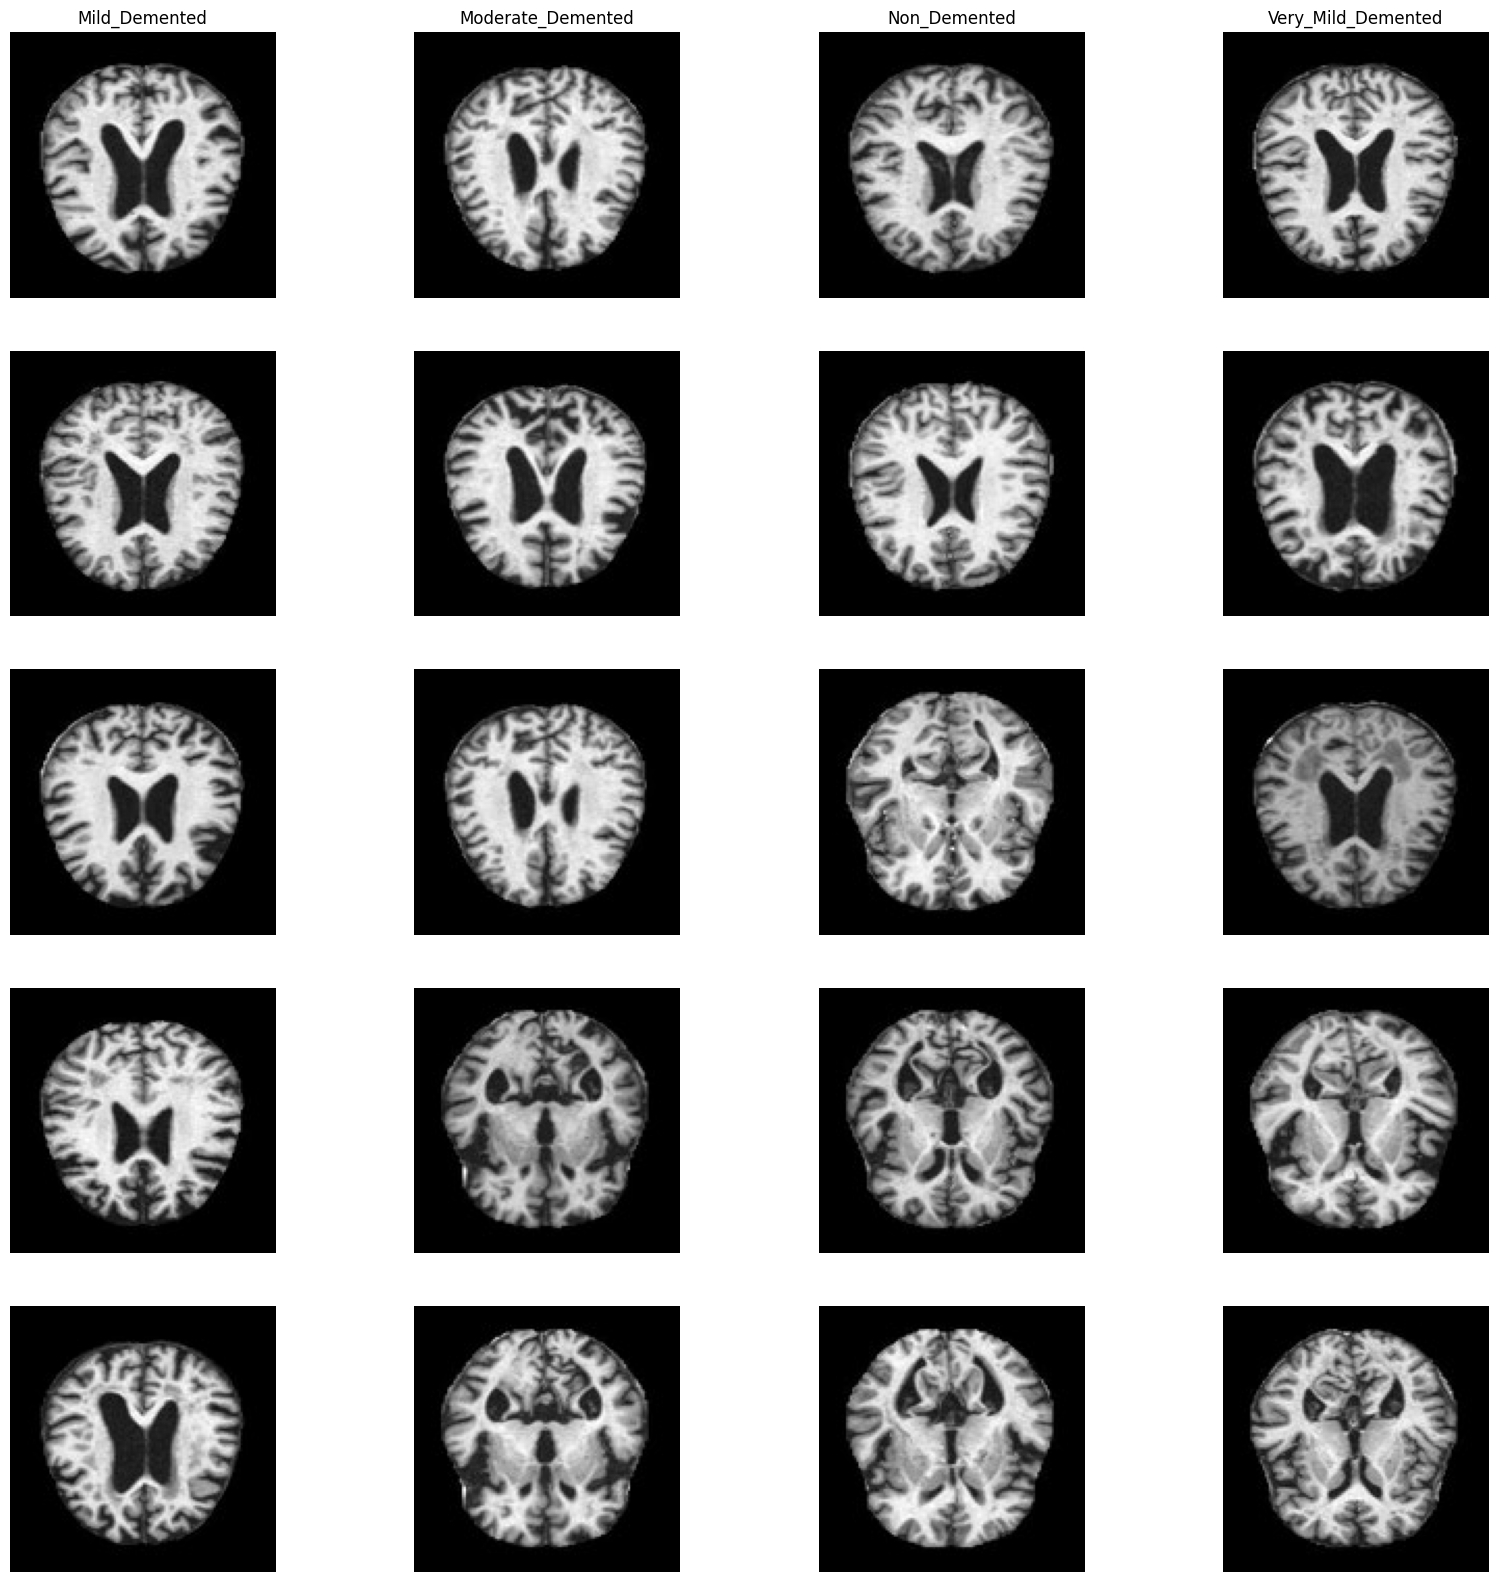

In [35]:
# let's create a dictionary where:
# - keys are folder names (-> the 8 classes)
# - values are the filenames for the files in each folder
imgs = {c: glob(join(train_path, c, "*")) for c in classes}

for key in imgs.keys():
   print("{} class has {} samples".format(key,len(imgs[key])))

nrows=5

# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES

fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i,(c,fnames) in enumerate(imgs.items()): # i is the count, (images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname=(fnames[n]).replace('\\','/')
        im= Image.open(fname)
        gray_im = im.convert('L')
        axs[n,i].imshow(gray_im, cmap='gray')
for ax in axs.flatten():
    ax.axis("off")

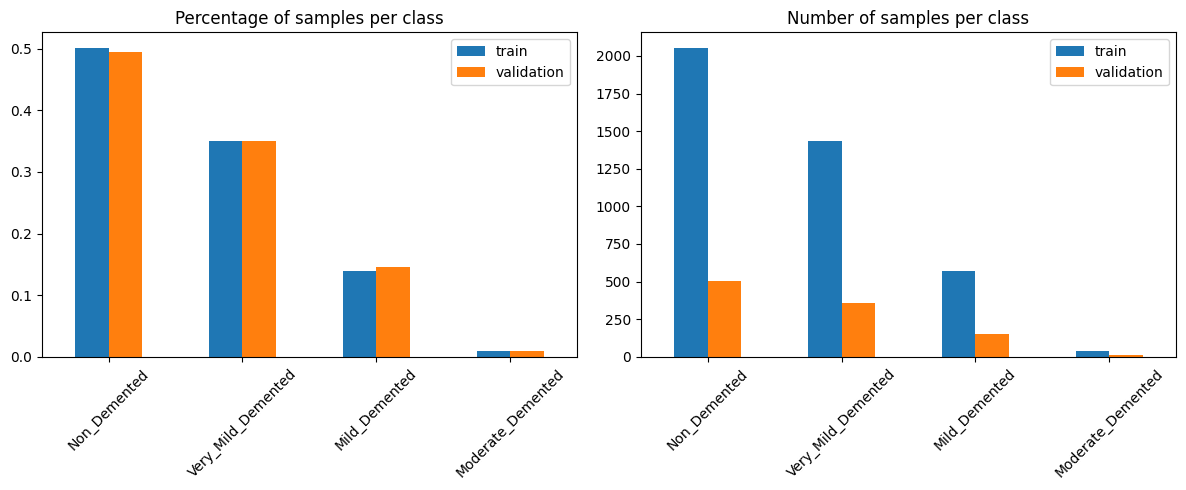

In [41]:
train_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_labels = np.concatenate([y for _, y in val_ds], axis=0)
train_labels = [train_ds.class_names[idx] for idx in train_labels]
val_labels = [val_ds.class_names[idx] for idx in val_labels]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45)
axs[0].legend(['train', 'validation'])

plt.subplot(1,2,2)
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45)
axs[1].legend(['train', 'validation'])

plt.tight_layout()

# Show the plot
plt.show()

Is possible to see how the dataset is unbalanced, is usefull to apply data aumentation in a specific manner for each class in order to prevent understimation of the minority class.

In [ ]:
## DATA AUGMENTATION

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [42]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [43]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [52]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [58]:
def dense_block(units, dropout_rate, L2): # add regularization at the dense layer (dense layer has are more or less fulliconnected, is important to reguraraze weight in order to avoid overfitting)
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [59]:
def build_model(L2,drop_out):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(drop_out),
        
        conv_block(256),
        tf.keras.layers.Dropout(drop_out),
        
        tf.keras.layers.Flatten(),
        dense_block(512, drop_out*3, L2),
        dense_block(128, drop_out*2, L2),
        dense_block(64, drop_out, L2),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
tf.keras.utils.plot_model(model, to_file="cnn.png", show_shapes=True) #plot the network

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [55]:
def exponential_decay(s):
    def exponential_decay_fn(epoch):
        return 0.001 **(epoch / s)
    return exponential_decay_fn



Let's fit our model!

In [73]:
from sklearn.model_selection import ParameterGrid
from scikeras.wrappers import KerasClassifier 
from sklearn.model_selection import RandomizedSearchCV


#Hyperparameter
hyperparameter = {
    'EPOCHS' : [10, 20, 30],
    'drop_out' : [0.1, 0.2, 0.3],
    's' : [5, 20, 30],
    'L2' : [1e-4, 1e-3, 1e-2]
}

hyperparam_grid = ParameterGrid(hyperparameter) #possible combination of hiperparameter

history = dict()

for p in hyperparam_grid:
    EPOCHS = p['EPOCHS']
    drop_out = p['drop_out']
    s = p['s']
    L2 = p['L2']

    model_name = 'EP_'+str(EPOCHS)+'_lr0_'+str(lr0)+'_s_'+str(s)+'_L2_'+str(L2)+'.h5'

    with strategy.scope():
        model = build_model(L2,drop_out)

        METRICS = [tf.keras.metrics.AUC(name='auc')]
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS
        )

    exponential_decay_fn = exponential_decay(s)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)          #each try has to be saved in a different model
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    history[model_name] = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
        train_ds,
        shuffle=True,
        batch_size = BATCH_SIZE,
        validation_data=valid_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
        verbose = 1, #progression bar
        epochs=EPOCHS
    )


Epoch 1/5
320/320 [==============================] - ETA: 0s - loss: 979.2399 - auc: 0.6149

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 98s 285ms/step - loss: 979.2399 - auc: 0.6149 - val_loss: 616.9674 - val_auc: 0.5639 - lr: 1.0000
Epoch 2/5
320/320 [==============================] - 88s 276ms/step - loss: 628.4229 - auc: 0.6405 - val_loss: 4394.2920 - val_auc: 0.4187 - lr: 0.8913
Epoch 3/5
320/320 [==============================] - 85s 266ms/step - loss: 1090.2539 - auc: 0.6677 - val_loss: 11271.5635 - val_auc: 0.3396 - lr: 0.7943
Epoch 4/5
320/320 [==============================] - 86s 269ms/step - loss: 571.6398 - auc: 0.6462 - val_loss: 617.6682 - val_auc: 0.8030 - lr: 0.7079
Epoch 5/5
320/320 [==============================] - 86s 269ms/step - loss: 359.6214 - auc: 0.6654 - val_loss: 223.8029 - val_auc: 0.4554 - lr: 0.6310
Epoch 1/5
320/320 [==============================] - 94s 276ms/step - loss: 2606.8584 - auc: 0.6052 - val_loss: 3068.3645 - val_auc: 0.5760 - lr: 1.0000
Epoch 2/5
320/320 [==============================] - 86s 270ms/step - loss: 2763.3516 - auc: 0.628

KeyboardInterrupt: 

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

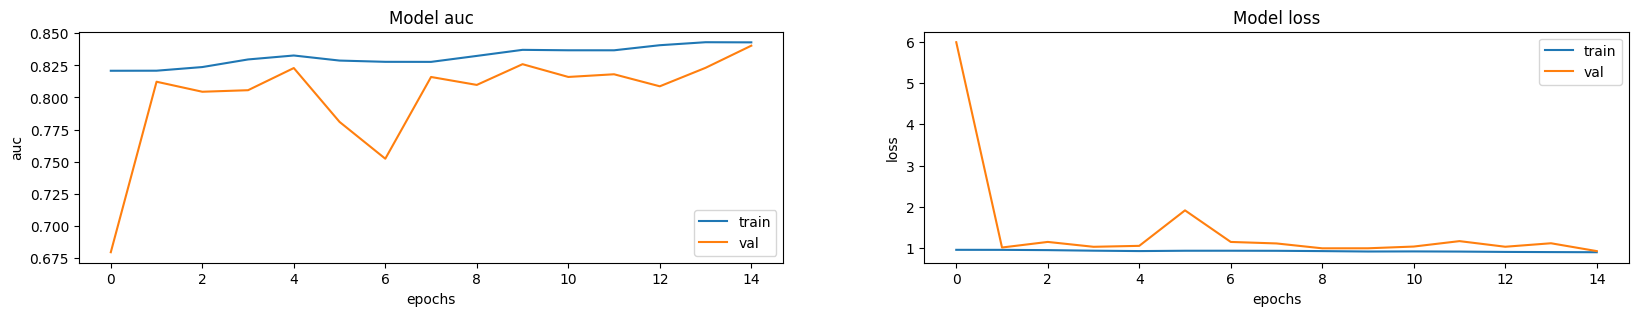

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [39]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6241 files belonging to 4 classes.


In [40]:
_ = model.evaluate(test_ds)

391/391 [==============================] - 24s 61ms/step - loss: 0.9172 - auc: 0.8470
